# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [25]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data import *
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from refinedet import build_refinedet

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [20]:
net = build_refinedet('test', voc, 320, 21)    # initialize SSD
from data import VOC_CLASSES as labels
# net = build_refinedet('test', coco, 320, 81)    # initialize SSD
# from data import COCO_CLASSES as labels
net.load_weights('../weights/refinedet320_VOC_50000.pth')

Initializing weights...
Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

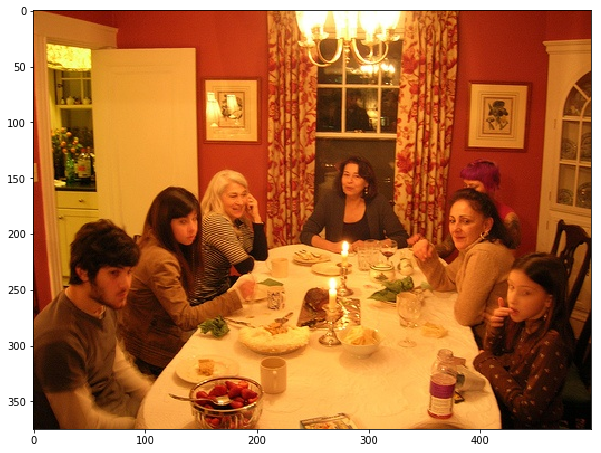

In [21]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
import pdb
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
# img_id = 60
img_id = 60
image = testset.pull_image(img_id)
# pdb.set_trace()
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

In [22]:
x = cv2.resize(image, (320, 320)).astype(np.float32)

# import pdb
# pdb.set_trace()
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
# plt.imshow(x / 255.0)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [23]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

torch.Size([1, 21, 200, 5])
20
0.570836126804
[ 354.35351562  299.94299316  381.40475464  365.19613647]
0.734099507332
[  78.22956085  208.33088684  446.40463257  380.9666748 ]
0.938366055489
[ 234.8625946   137.47425842  331.76293945  211.52268982]
0.920441150665
[  84.18871307  163.45709229  207.23130798  358.62734985]
0.897560179234
[ 352.95431519  152.40324402  423.15136719  297.13024902]
0.832002520561
[ 150.30418396  144.38870239  208.98580933  241.42585754]


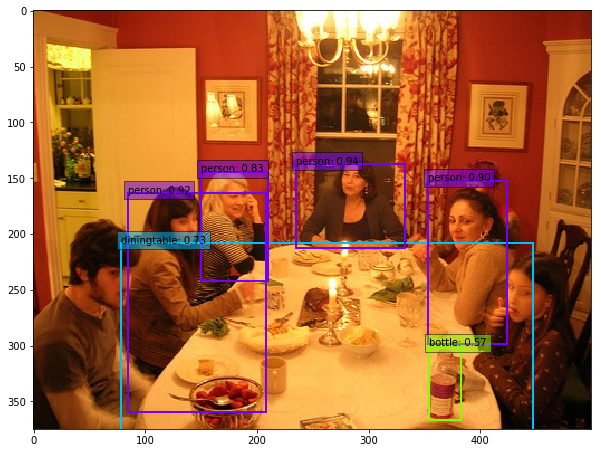

In [26]:

top_k=10
num_classes = len(labels)
# num_classes = 1
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, num_classes+1)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
print(detections.size())
print(len(labels))
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(1, detections.size(1)):
# for i in range(0, 1):
    j = 0
    while detections[0,i,j,0] >= 0.5:
        score = detections[0,i,j,0]
        print(score)
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        print(pt)
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1